Notebook created by Forrest Hooton

In [1]:
from time import time
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
import os
os.chdir('..')

In [4]:
from config import mfp
from src.data_loader import *
import src.collected_data_handling as cdh
from src.plot_utils import clean_plot

# Loading and Formatting Data

### The analysis code is designed to be run per food. Run with i=1 for garlic, and i=2 for cocoa

In [5]:
i = 2

def food_config(i):
    if i == 1:
        food = 'garlic'
    elif i == 2:
        food = 'cocoa'
    
    return food

food = food_config(i)
load = True

## Pilot Data

In [6]:
food_data, food_scoring = load_raw_data(food, load)

# Note: Keys appended October 2018. Keys subject to change with changing PubMed database.
food_data = append_keys_raw_data(food_data, food, load)
food_data = clean_raw_data_strings(food_data)
food_data_q, food_data_dnq = partition_raw_data(food_data, food_scoring)

food_mine, quant_food_mine, unquant_food_mine = build_food_mine(food_data, food_data_q, food_data_dnq)

food_mine.to_pickle(mfp(f'FoodMine_Notable_Files/fm_{food}.pkl'))
food_mine[['chemical', 'chem_id']].to_csv(mfp(f'FoodMine_Notable_Files/compound_names_{food}.csv'), index=False)

food_mine.to_pickle(mfp(f'misc_save/{food}_fm.pkl'))
quant_food_mine.to_pickle(mfp(f'misc_save/{food}_fm_quant.pkl'))
unquant_food_mine.to_pickle(mfp(f'misc_save/{food}_fm_unquant.pkl'))

In [7]:
# Number of unique papers in garlic_test.csv
print('Number of unique papers:', len(food_data['PMID'].drop_duplicates()))
print('Total number of records:', len(food_data))

Number of unique papers: 93
Total number of records: 5855


## Load FooDB and USDA Data

In [8]:
foodb_food, quant_foodb_food, unquant_foodb_food = load_foodb_data(food, load)
usda = load_usda_data(food, load)

# Numerical Database Comparison

In [9]:
def make_table(q1, uq1, q2, uq2, q1_identifier, q2_identifier, q1_strings, q2_strings, q1_val, q2_val):
    q1_ids = list(set( q1[q1[q1_identifier].notnull()][q1_identifier].tolist() + uq1[uq1[q1_identifier].notnull()][q1_identifier].tolist() ))
    q2_ids = list(set( q2[q2[q2_identifier].notnull()][q2_identifier].tolist() + uq2[uq2[q2_identifier].notnull()][q2_identifier].tolist() ))
    
    q2_quant_ids = list(set(q2[(q2[q2_val] > 0) & (q2[q2_identifier].notnull())][q2_identifier].tolist()))
    q2_zero_ids = list( set(q2[(q2[q2_val] == 0) & (q2[q2_identifier].notnull())][q2_identifier].tolist()) - set(q2_quant_ids) )
    
    uq2 = uq2[~uq2[q2_identifier].isin(set(q2[q2[q2_val] > 0][q2_identifier].tolist()))]
    
    q2_zero_ids = list( set(q2_zero_ids) - set(uq2[q2_identifier].tolist()) )
    
    q1_nonzero = q1[q1[q1_val] > 0]
    q1_zero = q1[q1[q1_val] == 0]
    
    table = pd.DataFrame({
        '' : ['quant', 'unquant', 'zeros', 'notin_q2'],
        'quant' : [
            len( q1_nonzero.merge(pd.DataFrame({q1_identifier : q2_quant_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_nonzero.merge(uq2, how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_nonzero.merge(pd.DataFrame({q1_identifier : q2_zero_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_nonzero[~q1_nonzero[q1_identifier].isin(q2_ids)].drop_duplicates([q1_strings, q1_identifier]) )
        ],
        'unquant' : [
            len( uq1.merge(pd.DataFrame({q1_identifier : q2_quant_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( uq1.merge(uq2, how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( uq1.merge(pd.DataFrame({q1_identifier : q2_zero_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( uq1[~uq1[q1_identifier].isin(q2_ids)] )
        ],
         'zeros' : [
            len( q1_zero.merge(pd.DataFrame({q1_identifier : q2_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_zero.merge(uq2, how='inner', on=q1_identifier).dropna(axis=0).drop_duplicates(q1_identifier) ),
            len( q1_zero.merge(pd.DataFrame({q1_identifier : q2_zero_ids}), how='inner', on=q1_identifier).dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) ),
            len( q1_zero[~q1_zero[q1_identifier].isin(q2_ids)].drop_duplicates([q1_strings, q1_identifier]) )
        ],
        'notin_q1' : [
            len( q2[(q2[q1_identifier].isin(q2_quant_ids)) & (~q2[q1_identifier].isin(q1_ids))].dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) )
            + len( q2[(q2[q2_val] > 0) & (q2[q1_identifier].isnull())][q2_strings].drop_duplicates() ),
            len( uq2[~uq2[q1_identifier].isin(q1_ids)].dropna(subset=[q1_identifier], axis=0)[q1_identifier].drop_duplicates() )
            + len( uq2[(~uq2[q1_identifier].isin(q1_ids)) & (uq2[q1_identifier].isnull())][q2_strings].drop_duplicates() ),
            len( q2[(q2[q1_identifier].isin(q2_zero_ids)) & (~q2[q1_identifier].isin(q1_ids))].dropna(subset=[q1_identifier], axis=0).drop_duplicates(q1_identifier) )
            + len( q2[(q2[q2_val] == 0) & (q2[q1_identifier].isnull())][q2_strings].drop_duplicates() ),
            0
        ]
    })
    
    table['total'] = table.sum(axis=1)
    table = table.append(table.sum(axis=0), ignore_index = True)
    table.at[4, ''] = 'total'
    
    display(table)


def grouped_relational_table(fm_q, fm_unq, fdb_q, fdb_unq, usda):
    comp_df = pd.concat([
        fdb_q[['name', 'chem_id', 'standard_content', 'chem_id_f']],
        usda[['nut_desc', 'chem_id', 'Nutr_Val', 'chem_id_f']].rename(columns={'nut_desc' : 'name', 'Nutr_Val' : 'standard_content'})
    ], ignore_index=True)
    
    make_table(fm_q, fm_unq, comp_df, fdb_unq, 'chem_id', 'chem_id', 'chemical', 'chem_id_f', 'average_mean', 'standard_content')

In [10]:
grouped_relational_table(quant_food_mine, unquant_food_mine, quant_foodb_food, unquant_foodb_food, usda)

,,quant,unquant,zeros,notin_q1,total
0,quant,57,11,0,60,128
1,unquant,54,8,0,1634,1696
2,zeros,1,0,0,28,29
3,notin_q2,283,183,1,0,467
4,total,395,202,1,1722,2320


In [11]:
ids = set(foodb_food.chem_id.tolist() + usda.chem_id.tolist())

unique_chems = quant_food_mine[~quant_food_mine.fillna('-').chem_id.isin(ids)]

report_stat(f'Num unique fm chems {food}: ' + str(len(unique_chems)),f'unique_chems_{food}.txt')

unique_chems.to_pickle(mfp(f'misc_save/{food}_unique_fm.pkl'))

In [12]:
quant_food_mine.to_pickle(mfp(f'misc_save/{food}_quant_fm.pkl'))

# Visualization Analysis

### Figure S1

,PMID,count
3,12059153,960


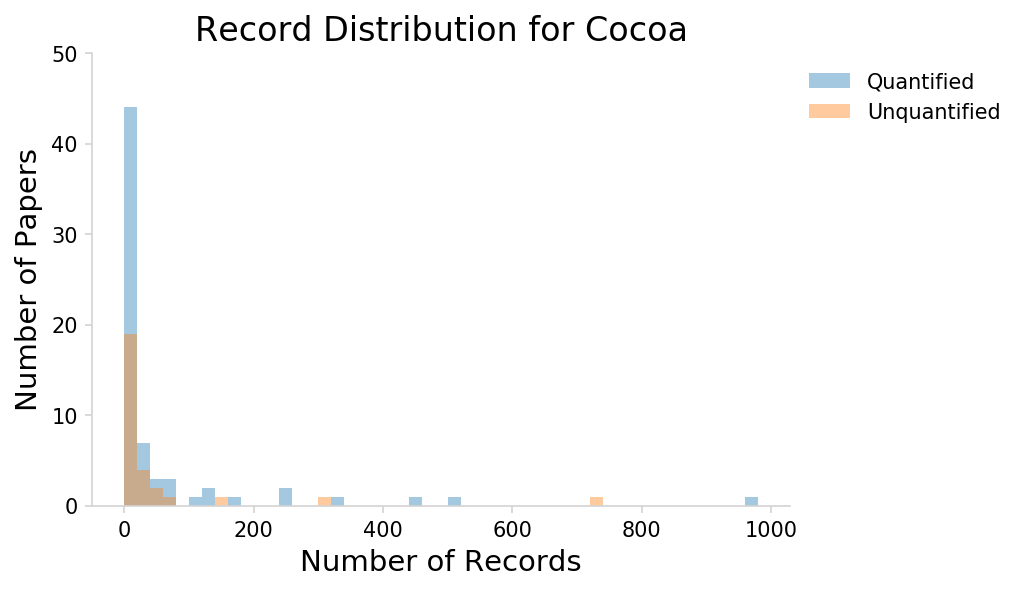

In [13]:
_, ax = plt.subplots(figsize=(6, 4))

# Distribution of chemical measurements per paper (number of records)
quant_viz = food_data_q.groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})
unquant_viz = food_data_dnq.groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})

yupperbound = 50
bins = list(range(0,1000,20))

display(quant_viz[quant_viz['count'] == max(quant_viz['count'])])

g1 = sns.distplot(quant_viz['count'], kde=False, label='Quantified', bins=bins)
g2 = sns.distplot(unquant_viz['count'], kde=False, label='Unquantified', bins=bins)
g1.set_ylim(top = yupperbound)
g1.set_xlabel('Number of Records', fontsize=14)
g1.set_ylabel('Number of Papers', fontsize=14)

g1.set_title(f'Record Distribution for {food.capitalize()}', fontsize=16)

g1.legend()
clean_plot()

,PMID,count
20,16848542,68


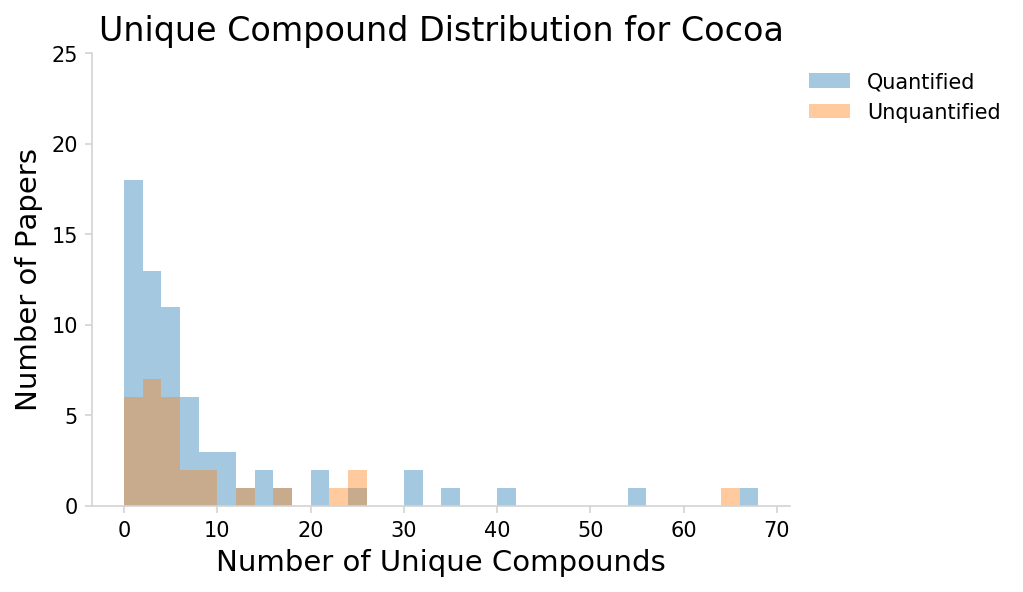

In [14]:
# Distribution of chemical measurements per paper (number of records)
quant_viz = food_data_q[['PMID', 'chemical']].drop_duplicates().groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})
unquant_viz = food_data_dnq[['PMID', 'chemical']].drop_duplicates().groupby('PMID').agg({'chemical' : 'count'}).reset_index().rename(columns={'chemical' : 'count'})

display(quant_viz[quant_viz['count'] == max(quant_viz['count'])])

yupperbound = 25
bins = list(range(0,70,2))

g1 = sns.distplot(quant_viz['count'], kde=False, label='Quantified', bins=bins)
g2 = sns.distplot(unquant_viz['count'], kde=False, label='Unquantified', bins=bins)
g1.set_ylim(top = yupperbound)
g1.set_xlabel('Number of Unique Compounds', fontsize=14)
g1.set_ylabel('Number of Papers', fontsize=14)

g1.set_title(f'Unique Compound Distribution for {food.capitalize()}', fontsize=16)

g1.legend()
clean_plot()

### Figure 2

In [15]:
# Load data for chemical classes
if food == 'garlic':
    classdata = pd.read_csv(mfp("data/Garlic_Quant_Cleaned.csv"), encoding='latin1')
if food == 'cocoa':
    classdata = pd.read_csv(mfp("data/cocoa_quant_cleaned.csv"), encoding='latin1').rename(columns={'Name' : 'name'})

classdata = classdata[['name','InChIKey', 'SuperClass', 'Class', 'SubClass']]
classdata.columns = ['chemical', 'InChiKey', 'SuperClass', 'Class', 'SubClass']
classdata = classdata[classdata.Class.notnull()]

No handles with labels found to put in legend.


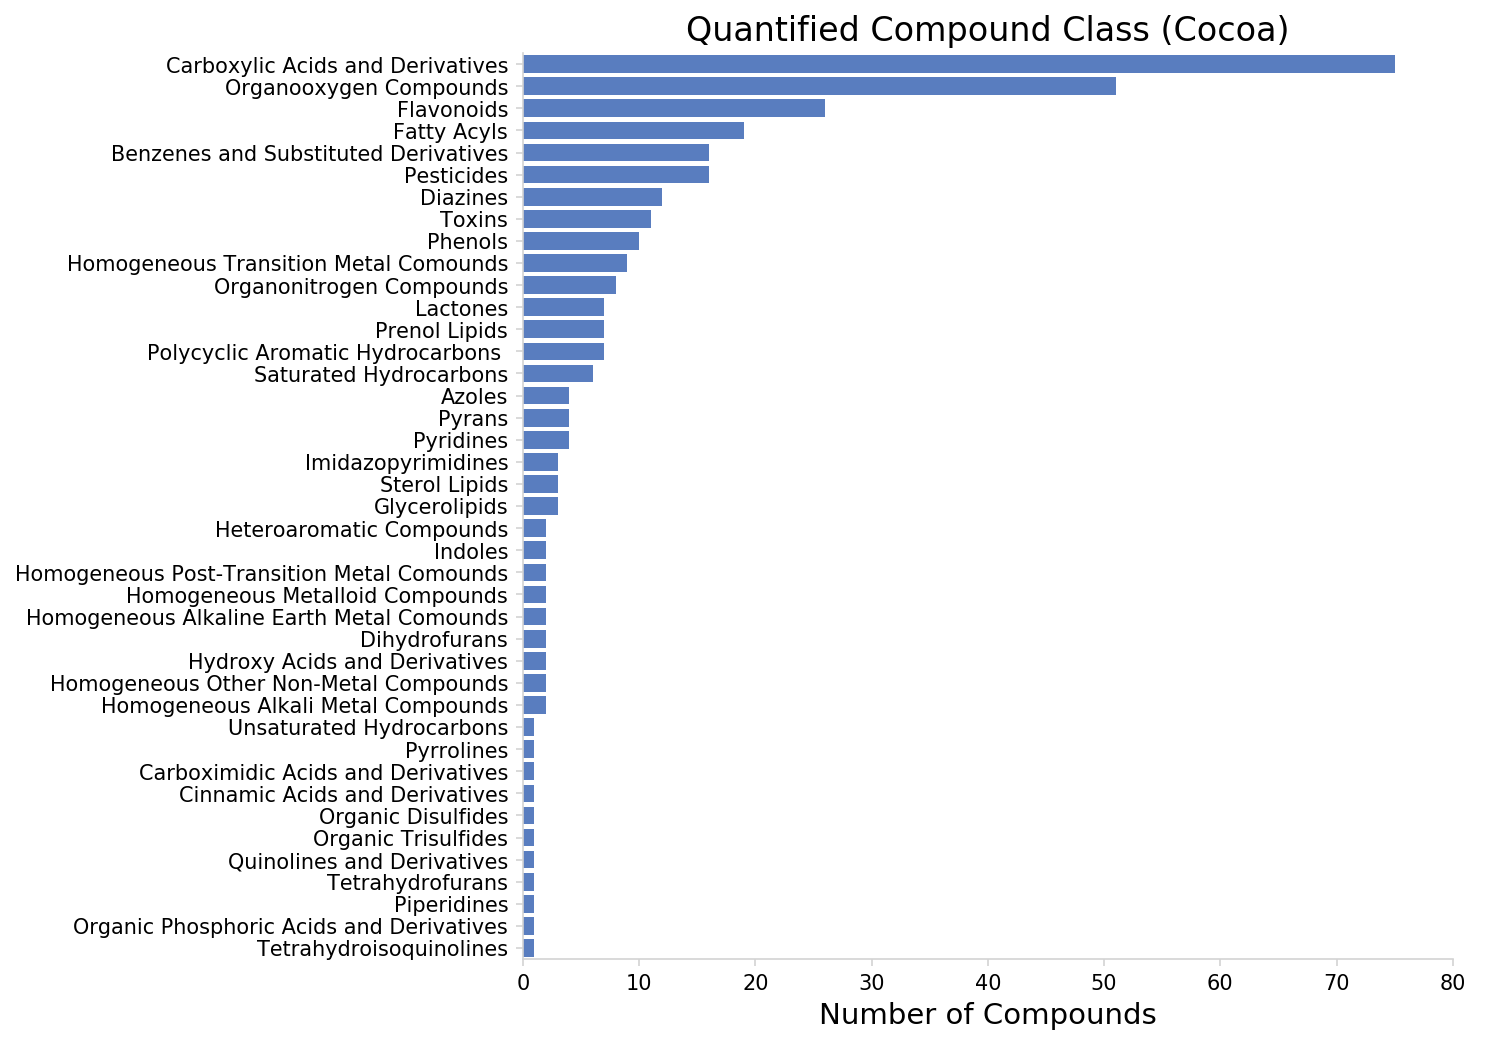

In [16]:
sns.set_color_codes(palette='muted')

fig, _ = plt.subplots(figsize=(8,8))
terms = classdata.Class.tolist()
top_n = 100 # Ensures all classes are present

counter = Counter(terms)

# Get counts of classes
counter = dict(counter.most_common(top_n))

# Extract ordered keys and corresponding values, then plot
terms = [str(k) for k in counter.keys()]
term_counts = list(counter.values())
ax = sns.barplot(term_counts, terms, color='b')

ax.set_title(f'Quantified Compound Class ({food.capitalize()})', fontsize=16)

ax.set_xlabel('Number of Compounds', fontsize=14)
ax.set_xlim([0, 80])
clean_plot()

### Figure 3

In [17]:
# Colors at https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
def partition_df(df, content_col, id_col, str_col):
    quant = df[df[content_col] > 0]
    unquant = df[(df[content_col].isnull()) & (~df[id_col].isin(set(quant[id_col].dropna().tolist())))
                & (~df[str_col].isin(set(quant[str_col].dropna().tolist())))]
    zeros = df[(df[content_col] == 0) & (~df[id_col].isin(set(quant[id_col].dropna().tolist() + unquant[id_col].dropna().tolist())))
              & (~df[id_col].isin(set(quant[str_col].dropna().tolist() + unquant[str_col].dropna().tolist())))]
    
    return quant, unquant, zeros

fdb_q, fdb_uq, fdb_z = partition_df(foodb_food,'standard_content', 'chem_id' , 'chem_id_f')

fdb_quant_num_nz = len(fdb_q[fdb_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(fdb_q[fdb_q.chem_id.isnull()].drop_duplicates('chem_id_f'))
fdb_quant_num_z = len(fdb_z[fdb_z.chem_id.notnull()].drop_duplicates('chem_id')) + len(fdb_z[fdb_z.chem_id.isnull()].drop_duplicates('chem_id_f'))
fdb_unquant_num = len(fdb_uq[fdb_uq.chem_id.notnull()].drop_duplicates('chem_id')) + len(fdb_uq[fdb_uq.chem_id.isnull()].drop_duplicates('chem_id_f'))

fm_q, fm_uq, fm_z = partition_df(food_mine,'average_mean', 'chem_id', 'chemical')

fm_q_nz = len(fm_q[fm_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(fm_q[fm_q.chem_id.isnull()].drop_duplicates('chemical'))
fm_q_z = len(fm_z[fm_z.chem_id.notnull()].drop_duplicates('chem_id')) + len(fm_z[fm_z.chem_id.isnull()].drop_duplicates('chemical'))
fm_nuq = len(fm_q[fm_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(fm_q[fm_q.chem_id.isnull()].drop_duplicates('chemical'))


u_q, u_uq, u_z = partition_df(unique_chems,'average_mean', 'chem_id', 'chemical')

fm_u_nz = len(u_q[u_q.chem_id.notnull()].drop_duplicates('chem_id')) + len(u_q[u_q.chem_id.isnull()].drop_duplicates('chemical'))
fm_u_z = len(u_z[u_z.chem_id.notnull()].drop_duplicates('chem_id')) + len(u_z[u_z.chem_id.isnull()].drop_duplicates('chemical'))

unquantcolor = sns.color_palette("Paired", 10)[1]
quantcolor = sns.color_palette("Paired", 10)[0]
uniquecolor = sns.color_palette("Paired")[6]

In [18]:
# Visualize final chems
disp_nums = {'db' : ['USDA', 'Foodb', 'FoodMine', 'FoodMine, New Info'],
             'Quantified' : [len(usda[usda.Nutr_Val != 0]), fdb_quant_num_nz, fm_q_nz, fm_u_nz],
             'Zeros' : [len(usda[usda.Nutr_Val == 0]), fdb_quant_num_z, fm_q_z, fm_u_z],
             'Unquantified' : [0, fdb_unquant_num, len(fm_uq), 0]}

disp_df = pd.DataFrame(disp_nums)

disp_df['total'] = disp_df['Quantified'] + disp_df['Zeros'] + disp_df['Unquantified']

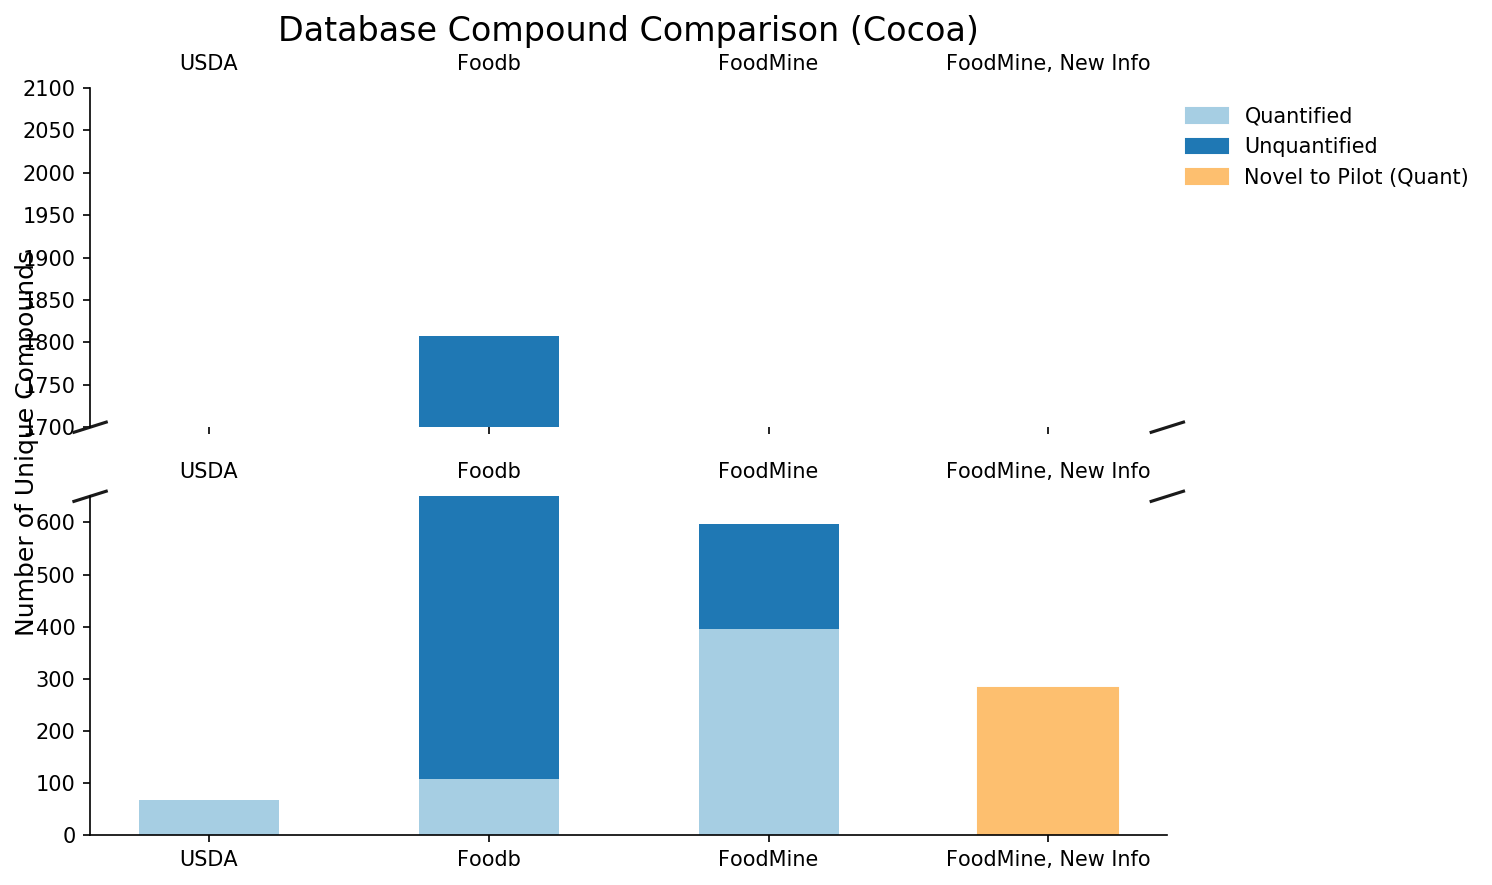

In [19]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

# plot the same data on both axes
index = np.arange(4)
bar_width = .5

ax.bar(index, disp_df['total'], bar_width, color = unquantcolor)

rects1 = ax2.bar(index, disp_df['Quantified'], bar_width, color = quantcolor)
rects2 = ax2.bar(index, disp_df['Unquantified'], bar_width, bottom = disp_df['Quantified'], color = unquantcolor)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(1700, 2100)  # outliers only
ax2.set_ylim(0, 650)  # most of the data

# Set the ticks and ticklabels for all axes
plt.setp(ax2, xticks=index, xticklabels=disp_df['db'].tolist())

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.tick_params(labeltop='off', bottom='off')  # don't put tick labels at the top
ax2.tick_params(labeltop='off', bottom='off')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

f.text(0.01, 0.5, 'Number of Unique Compounds', va='center', rotation='vertical', fontsize=12)
ax.set_title(f'Database Compound Comparison ({food.capitalize()})', fontsize=16)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

ax2.get_children()[3].set_color(uniquecolor)

patch1 = mpatches.Patch(color=quantcolor, label='Quantified')
patch2 = mpatches.Patch(color=unquantcolor, label='Unquantified')
patch3 = mpatches.Patch(color=uniquecolor, label='Novel to Pilot (Quant)')
ax.legend(handles = [patch1, patch2, patch3], frameon = False, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()


### Figure 4

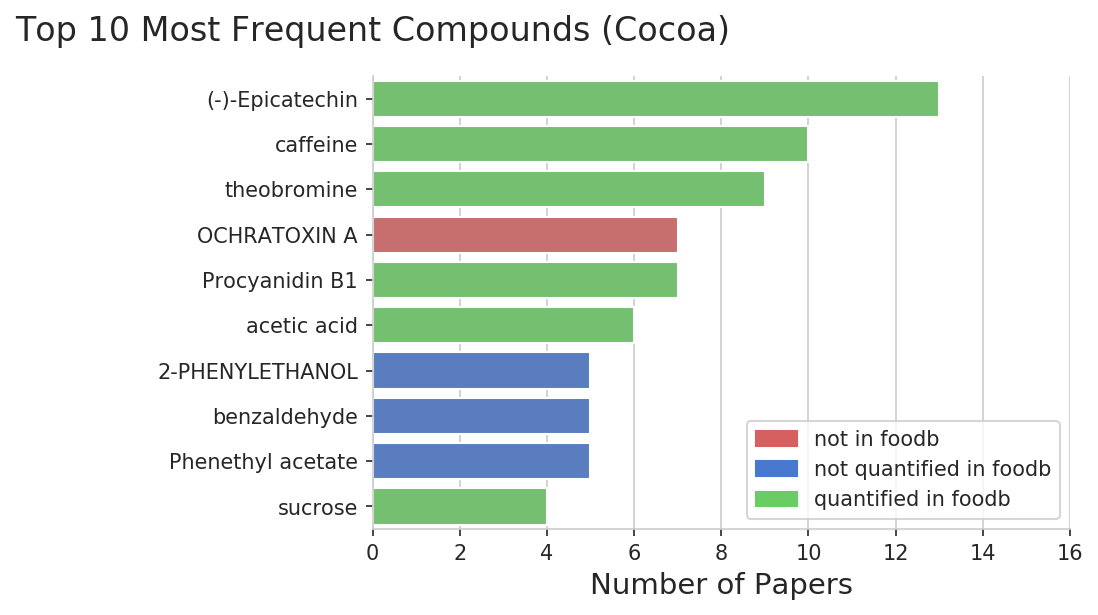

In [20]:
# Calculates top n for number of papers in which a chemical occurs
expanded_term_list = []
for idx, row in food_mine.iterrows():
    if row['chemical'] == 'fat':
        continue
    expanded_term_list += [row['chem_id']] * int(row['num_papers'])

# Note that this particular iteration doesn't account for id's that are NaN, but all top values seem to have id's anyways
id_to_name = []
for ID in expanded_term_list:
    name = food_mine[food_mine['chem_id'] == ID].chemical.tolist()
    
    if isinstance(name, list):
        if len(name) == 0:
            continue
        id_to_name.append(name[0])
    else:
        id_to_name.append(name)

terms = id_to_name
top_n = 10

title = f"Top 10 Most Frequent Compounds ({food.capitalize()})"

f_ids = set(foodb_food.chem_id.tolist())
f_q_ids = set( foodb_food[foodb_food.standard_content > 0].chem_id.tolist())

counter = Counter(terms)

counter = dict(counter.most_common(top_n))

terms = [str(k) for k in counter.keys()]
term_counts = list(counter.values())

sns.set_color_codes('muted')

c1 = 'r'
c2 = 'b'
c3 = 'g'

colors = []
labels = []
for v in terms:
    temp_id = food_mine[food_mine.chemical==v].chem_id.tolist()[0]
    
    if temp_id in f_q_ids:
        colors.append(c3) # quantified in foodb
    elif temp_id in f_ids:
        colors.append(c2) # not quantified in foodb
    else:
        colors.append(c1) # not in foodb

# Horizontal bar graph

with sns.axes_style('whitegrid'):

    ax = sns.barplot(term_counts, terms, palette=colors)
    ax.set_xlabel('Number of Papers', fontsize=14)
    ax.set_title(title, fontsize = 16)
    ax.title.set_position([0, 1.05])

    patch1 = mpatches.Patch(color=c1, label='not in foodb')
    patch2 = mpatches.Patch(color=c2, label='not quantified in foodb')
    patch3 = mpatches.Patch(color=c3, label='quantified in foodb')
    ax.legend(handles = [patch1, patch2, patch3])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(right = 16)


### Figure 5

In [21]:
usda_mod = usda[(usda.unit != 'IU') & (usda.chem_id.notnull())]

for idx, row in usda_mod.iterrows():
    try:
        usda_mod.at[idx, 'usda_amount'] = cdh.__unit_handler__(row['Nutr_Val'], row['unit'] + '/100g', 'mg/100g')
    except:
        pass

usda_mod['units'] = 'mg/100g'

usda_mod.to_pickle(mfp(f'misc_save/{food}_usda_conv.pkl'))

C:\software\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\software\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\software\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [22]:
val_comparison = quant_food_mine.merge(usda_mod[['chem_id','usda_amount']].groupby('chem_id').mean().reset_index(),
                                       how = 'inner', on = 'chem_id')
val_comparison = val_comparison[val_comparison.num_terms_quantified != 0]
val_comparison = val_comparison[(val_comparison.average_mean != 0) & (val_comparison.usda_amount != 0)]
val_comparison = val_comparison.sort_values(by=['average_mean'], ascending=False).reset_index(drop=True)

No handles with labels found to put in legend.


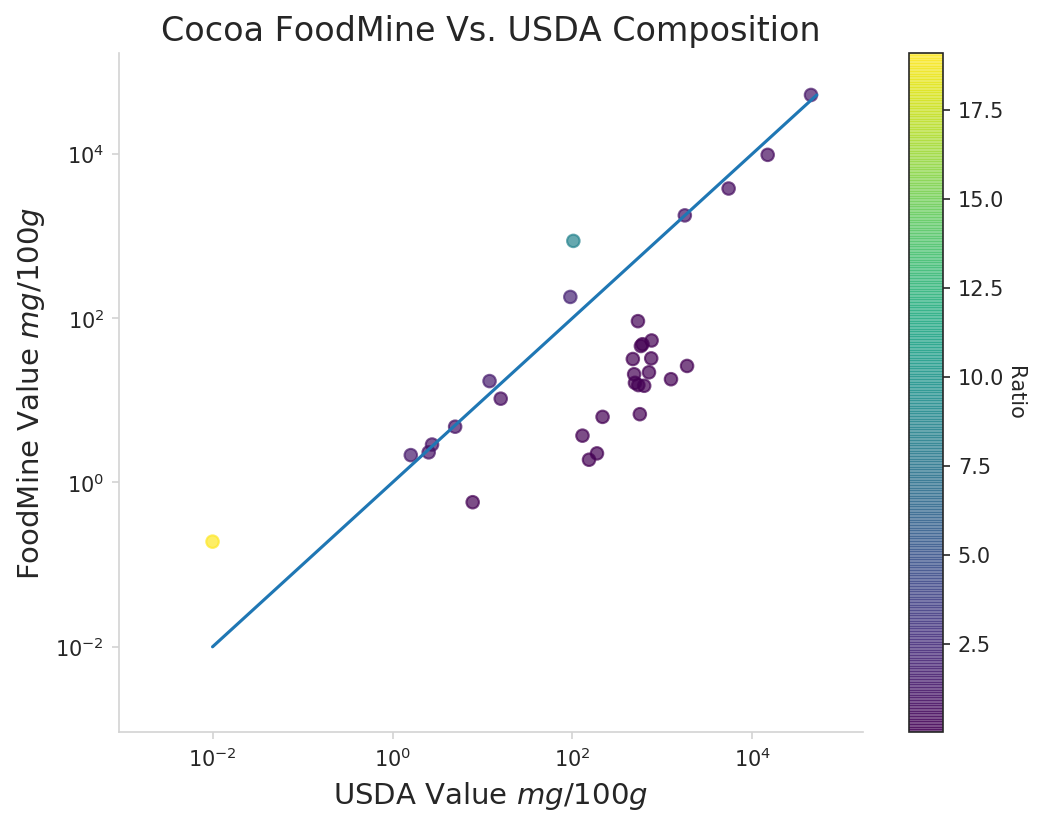

In [23]:
import math
import scipy

color_values = [(row['average_mean'])/(row['usda_amount']) for _, row in val_comparison.iterrows()]

input1 = val_comparison['usda_amount'].tolist()
input2 = val_comparison['average_mean'].tolist()

x_min = 10**-3
x_max = 10**5
y_min = 10**-3
y_max = 10**5

if x_min == 0 or y_min == 0:
    x_min = max(x_min,y_min)
    y_min = max(x_min,y_min)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot([min(input1), max(input2)],[min(input1), max(input2)])

    f = ax.scatter(input1, input2, c=color_values,
               cmap='viridis', marker='o', alpha=.7)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([x_min * .9, x_max * 1.7])
    ax.set_ylim([y_min * .9, y_max * 1.7])

    ax.set_xlabel(r"USDA Value $mg/100g$", fontsize=14)
    ax.set_ylabel(r"FoodMine Value $mg/100g$", fontsize=14)
    
    ax.set_title(f'{food.capitalize()} FoodMine Vs. USDA Composition', fontsize=16)

    cbar = plt.colorbar(f)
    cbar.set_label('Ratio', rotation=270, labelpad=+10)

    wnames = False
    if wnames:
        for i, txt in enumerate(val_comparison.chemical.tolist()):
            plt.annotate(txt, (input1[i] * 1.1, input2[i]))

clean_plot()

corr = scipy.stats.pearsonr(val_comparison.average_mean.apply(np.log), val_comparison.usda_amount.apply(np.log))[0]**2
report_stat(f'perc {food} fm data used w/ usda: ' + str(len(val_comparison)/len(food_mine)), f'fm_usda_overlap_perc_{food}.txt')
report_stat(f'FM-USDA log R2 {food}: ' + str(corr), f'fm_usda_r2_{food}.txt')

In [24]:
def filter_papers(l, v=None):
    if v in l:
        return True
    else:
        return False

new_calc = val_comparison[~val_comparison.papers.apply(filter_papers, v=16848542)]
corr = scipy.stats.pearsonr(new_calc.average_mean.apply(np.log), new_calc.usda_amount.apply(np.log))[0]**2
report_stat(f'FM-USDA removed paper log R2 {food}: ' + str(corr), f'fm_usda_r2_r_{food}.txt')

In [25]:
import statsmodels.api as sm

X = val_comparison.average_mean.apply(np.log)
Y = val_comparison.usda_amount.apply(np.log)

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            usda_amount   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     37.82
Date:                Sat, 01 Aug 2020   Prob (F-statistic):           9.18e-07
Time:                        20:15:37   Log-Likelihood:                -67.295
No. Observations:                  32   AIC:                             138.6
Df Residuals:                      30   BIC:                             141.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4317      0.568      4.280   

C:\software\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [26]:
X = new_calc.average_mean.apply(np.log)
Y = new_calc.usda_amount.apply(np.log)

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            usda_amount   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     35.08
Date:                Sat, 01 Aug 2020   Prob (F-statistic):           7.00e-05
Time:                        20:15:37   Log-Likelihood:                -29.501
No. Observations:                  14   AIC:                             63.00
Df Residuals:                      12   BIC:                             64.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.1032      0.715      1.542   

C:\software\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


### Sample Characteristics

In [27]:
def calc_sample_charachteristics(food, char):
    num_char_pmids = len(food[(food['variation'].fillna('').str.lower().str.contains(char)) | (food['part'].fillna('').str.lower().str.contains(char))]['PMID'].drop_duplicates().to_list())
    return num_char_pmids / len(food['PMID'].drop_duplicates())


In [28]:
garlic = pd.read_csv(mfp(f'data/garlic_data.csv'), encoding='latin1')

No handles with labels found to put in legend.


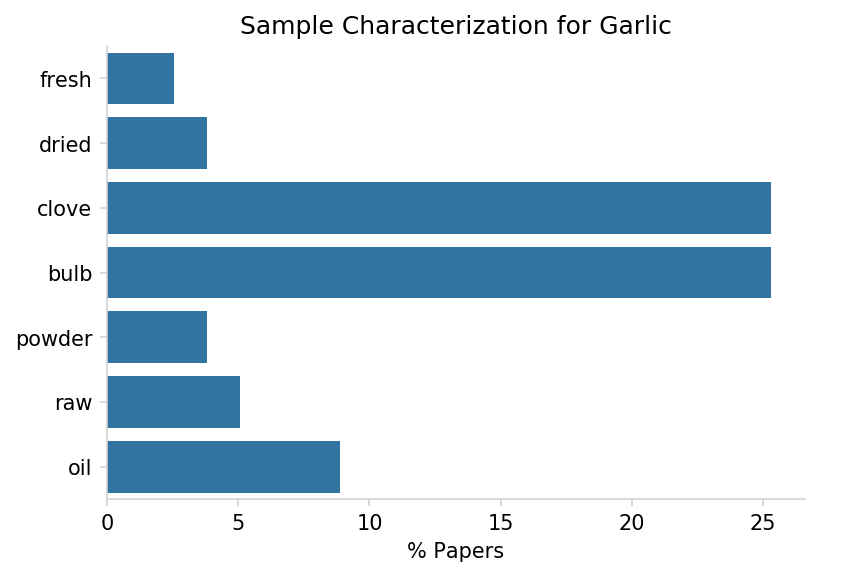

In [29]:
g_vars = {
    'fresh' : calc_sample_charachteristics(garlic, 'fresh'),
    'dried' : calc_sample_charachteristics(garlic, 'dried'),
    'clove' : calc_sample_charachteristics(garlic, 'clove'),
    'bulb' : calc_sample_charachteristics(garlic, 'bulb'),
    'powder' : calc_sample_charachteristics(garlic, 'powder'),
    'raw' : calc_sample_charachteristics(garlic, 'raw'),
    'oil' : calc_sample_charachteristics(garlic, 'oil'),
}

ax = sns.barplot(y=list(g_vars.keys()), x=[v * 100 for v in g_vars.values()], color='tab:blue')
ax.set_xlabel('% Papers')
ax.set_title('Sample Characterization for Garlic')
clean_plot()

In [30]:
cocoa = pd.read_csv(mfp(f'data/cocoa_data.csv'), encoding='latin1')

No handles with labels found to put in legend.


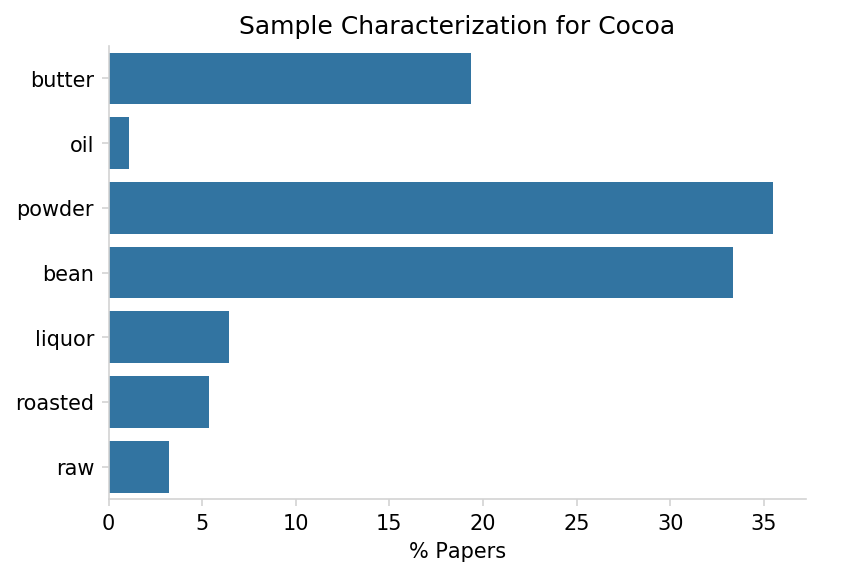

In [31]:
c_vars = {
    'butter' : calc_sample_charachteristics(cocoa, 'butter'),
    'oil' : calc_sample_charachteristics(cocoa, 'oil'),
    'powder' : calc_sample_charachteristics(cocoa, 'powder'),
    'bean' : calc_sample_charachteristics(cocoa, 'bean'),
    'liquor' : calc_sample_charachteristics(cocoa, 'liquor'),
    'roasted' : calc_sample_charachteristics(cocoa, 'roast'),
    'raw' : calc_sample_charachteristics(cocoa, 'raw'),
}

ax = sns.barplot(y=list(c_vars.keys()), x=[v * 100 for v in c_vars.values()], color='tab:blue')
ax.set_xlabel('% Papers')
ax.set_title('Sample Characterization for Cocoa')
clean_plot()